<a href="https://colab.research.google.com/github/andydaehn/Drug_Classification/blob/main/Drug_Classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drug Classification Analysis

This analysis will help predict the best drug to use for a particular patient, based on medical data from 200 patients, by classifying the patient to the drug profile.

## Import Libraries and Data

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, r2_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from IPython.display import display # Allows the use of display() for DataFrames

# Pretty display for notebooks
%matplotlib inline

# Ensure visualizations can be viewed by all
vis_color = 'colorblind'
hex_color = '#004c99'

# Load the dataset
feat_df = pd.read_csv('drug200.csv')

# Exploratory Data Analysis

In [2]:
# Make it easy to see basic information
def get_basic_info():
    display(feat_df.head())
    display(feat_df.describe())
    display(feat_df.info())
get_basic_info()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


None

### Analysis of Numerical Features

In [3]:
# Combine all numerical features
numerical_cols = feat_df.select_dtypes(include=np.number).columns.to_list()
numerical_cols

['Age', 'Na_to_K']

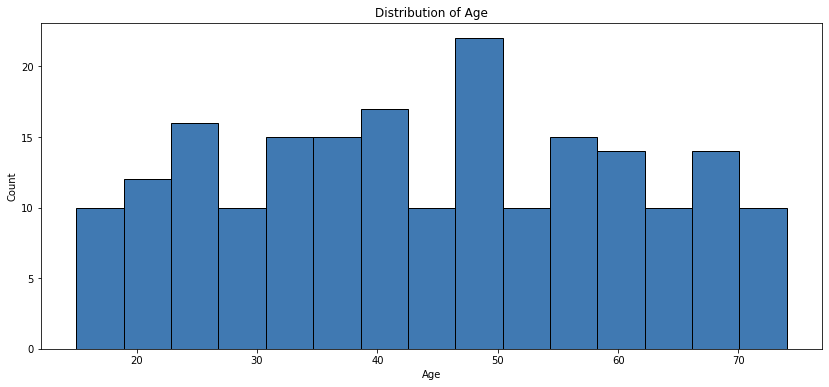

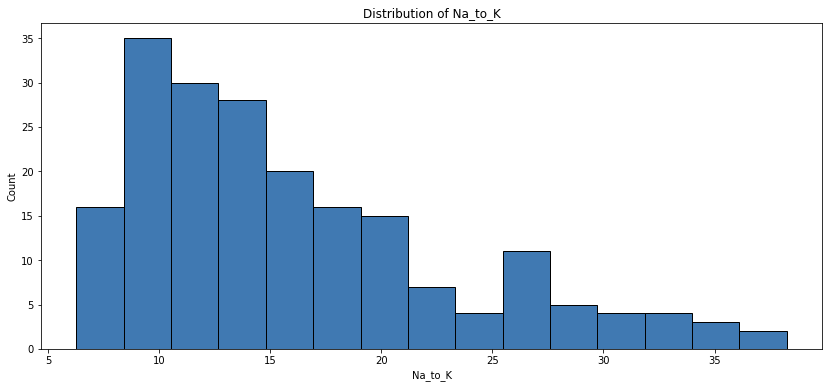

In [4]:
# Plot numerical column
for col in numerical_cols:
    plt.figure(figsize=(14,6))
    sns.histplot(data=feat_df,x=col,bins=15,color=hex_color)
    plt.title(f"Distribution of {col}")

**Inference:** Na_to_k has a positive skew. Check skewness and kurtosis of Na_to_K

In [5]:
# Skewness and kurtosis
print("Skewness: %f" % feat_df['Na_to_K'].skew())


Skewness: 1.039341


### Analysis of Categorical Features

In [6]:
# Combine all categorical features
categorical_cols=feat_df.select_dtypes(include=object).columns.to_list()
categorical_cols

['Sex', 'BP', 'Cholesterol', 'Drug']

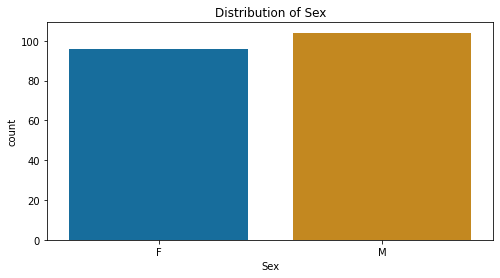

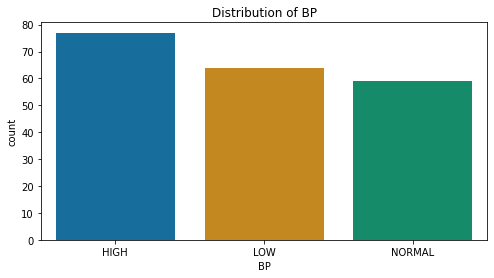

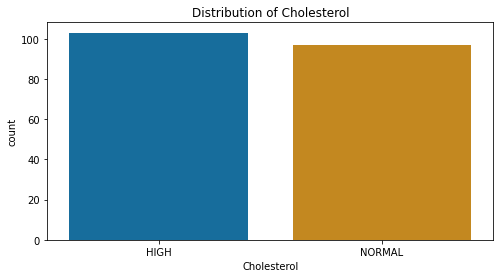

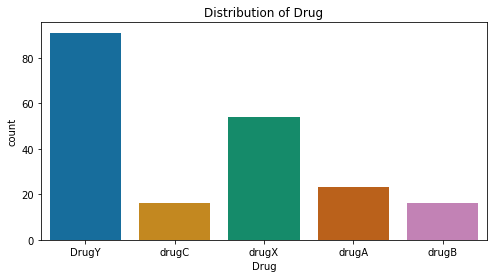

In [7]:
# Plot categorical columns
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=feat_df,x=col,palette=vis_color)
    plt.title(f"Distribution of {col}")

**Inference**: Drug Y is widely used compared to other drugs.

## Bivariate Analysis

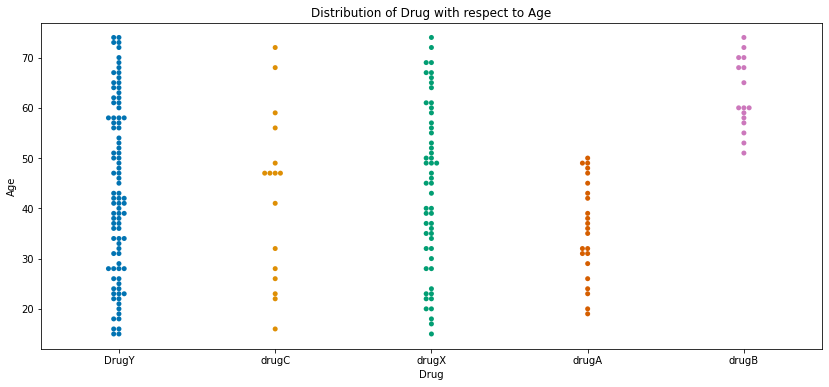

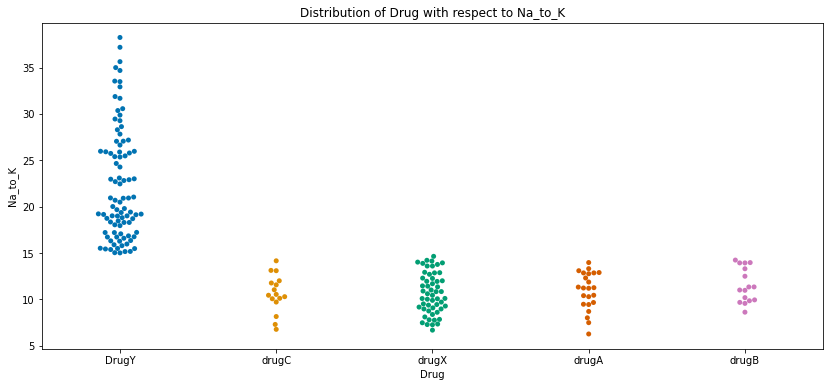

In [8]:
# Bivariate for numerical columns
for col in numerical_cols:
    plt.figure(figsize=(14,6))
    sns.swarmplot(data=feat_df,x='Drug',y=col,palette=vis_color)
    plt.title(f"Distribution of Drug with respect to {col}")

**Inference:** Age may have a correlation with drugA and drugB. Na_to_K appears to have a high correlation to drugY.

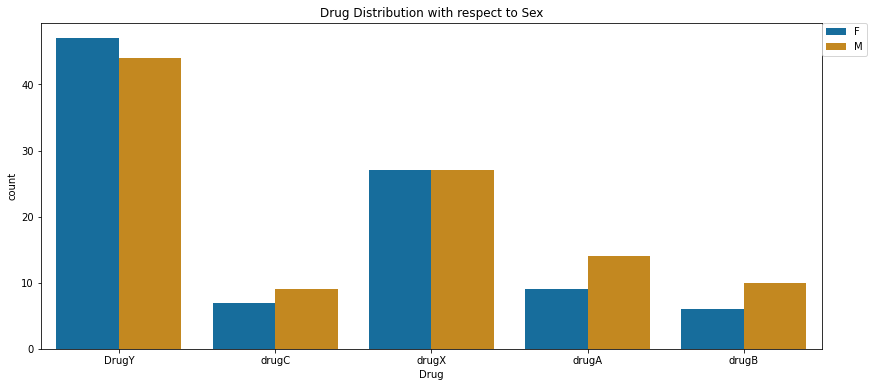

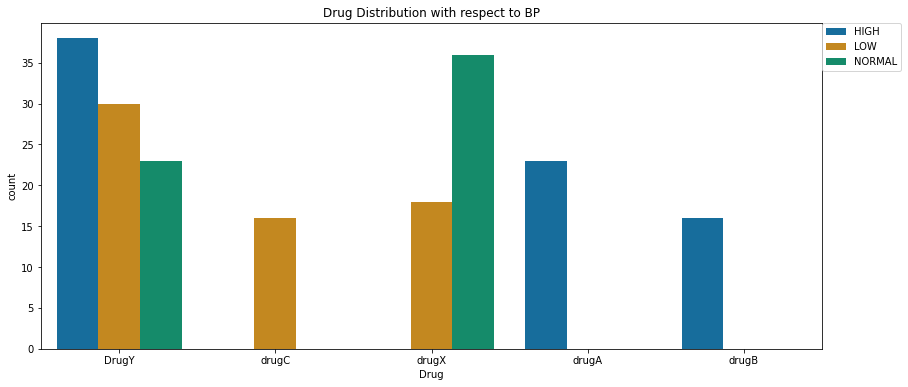

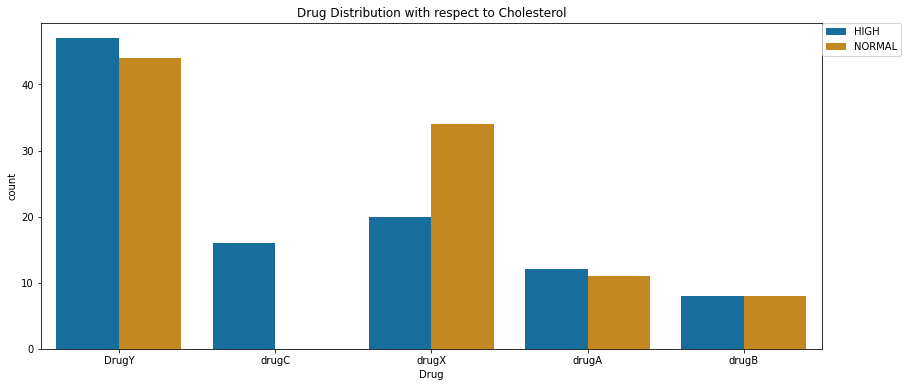

In [9]:
# Bivariate for categorical columns
for col in categorical_cols:
    if col=='Drug':
        continue   
    plt.figure(figsize=(14,6))
    sns.countplot(data=feat_df,x='Drug',hue=col,palette=vis_color)
    plt.legend(bbox_to_anchor=(1.0,1.0),loc='upper left',borderaxespad=0)
    plt.title(f"Drug Distribution with respect to {col}")

**Inference:** Sex appears to have little influence on which drug is used.

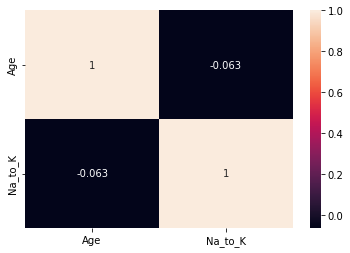

In [10]:
corrMatrix = feat_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

## Data Wrangling


### Apply log1p to manage the outliers in Na_to_k

The original skewness and kurtosis of Na_to_K
Skewness: 1.039341


The new skewness and kurtosis of Na_to_K
Skewness: 0.350931


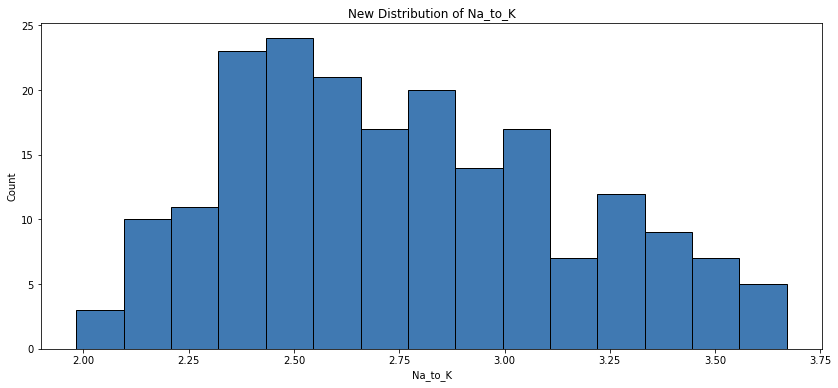

In [11]:
print('The original skewness and kurtosis of Na_to_K')
print("Skewness: %f" % feat_df['Na_to_K'].skew())

print('\n')

# Use log1p to adjust the skewness and kurtosis
feat_df['Na_to_K'] = np.log1p(feat_df['Na_to_K'])

#Plot new
plt.figure(figsize=(14,6))
sns.histplot(data=feat_df,x='Na_to_K',bins=15,color=hex_color)
plt.title(f"New Distribution of Na_to_K")

print('The new skewness and kurtosis of Na_to_K')
print("Skewness: %f" % feat_df['Na_to_K'].skew())


In [12]:
# Split data into features and labels
y_df = feat_df['Drug']
X_df = feat_df.iloc[:,:5]
X_df



,Age,Sex,BP,Cholesterol,Na_to_K
0,23,F,HIGH,HIGH,3.271658
1,47,M,LOW,HIGH,2.645678
2,47,M,LOW,HIGH,2.408206
3,28,F,NORMAL,HIGH,2.174524
4,61,F,LOW,HIGH,2.946700
...,...,...,...,...,...
195,56,F,LOW,HIGH,2.531074
196,16,M,LOW,HIGH,2.565411
197,52,M,NORMAL,HIGH,2.388212
198,23,M,NORMAL,NORMAL,2.709383


In [13]:
# # Encode categorical variables
# from sklearn.preprocessing import LabelEncoder
# X_df.apply(LabelEncoder().fit_transform)
X_df = pd.get_dummies(X_df,['Sex','BP','Cholesterol'])
X_df

,Age,Na_to_K,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,23,3.271658,1,0,1,0,0,1,0
1,47,2.645678,0,1,0,1,0,1,0
2,47,2.408206,0,1,0,1,0,1,0
3,28,2.174524,1,0,0,0,1,1,0
4,61,2.946700,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
195,56,2.531074,1,0,0,1,0,1,0
196,16,2.565411,0,1,0,1,0,1,0
197,52,2.388212,0,1,0,0,1,1,0
198,23,2.709383,0,1,0,0,1,0,1


In [14]:
y_df = pd.get_dummies(y_df,['Drug'])
y_df

,['Drug']_DrugY,['Drug']_drugA,['Drug']_drugB,['Drug']_drugC,['Drug']_drugX
0,1,0,0,0,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,0,1
4,1,0,0,0,0
...,...,...,...,...,...
195,0,0,0,1,0
196,0,0,0,1,0
197,0,0,0,0,1
198,0,0,0,0,1


## Split, Train, and Test the Data

In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

In [16]:
# Train the data on the Random Forest Classifier and test the accuracy
RF = RandomForestClassifier()
RF.fit(X_train,y_train)
#y_pred = DTC.predict(X_test)
# Making predictions
y_train_pred = RF.predict(X_train)
y_test_pred = RF.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)


print('The training accuracy is', (train_accuracy*100),'%')
print('The test accuracy is', (test_accuracy*100),'%')


The training accuracy is 100.0 %
The test accuracy is 100.0 %


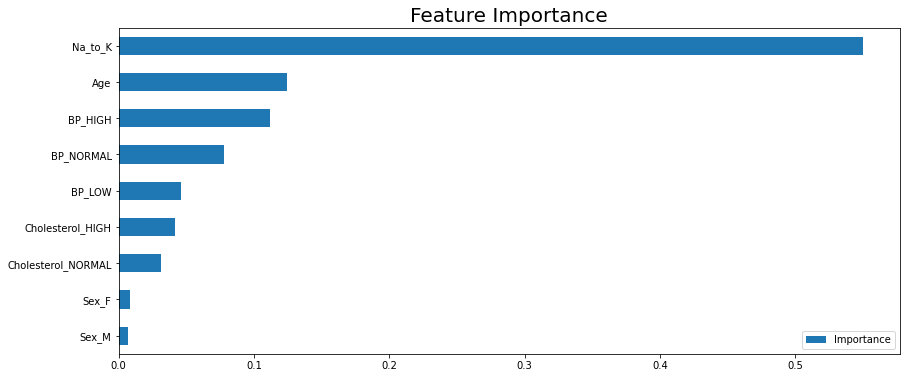

In [17]:
# Plot the import features
feature_importances = pd.DataFrame(RF.feature_importances_,index=X_df.columns.to_list(),columns=['Importance']).sort_values(by='Importance',ascending=True)
feature_importances.plot(kind='barh',figsize=(14,6));
plt.title("Feature Importance",fontsize=20);

In [18]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00        11

   micro avg       1.00      1.00      1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40
 samples avg       1.00      1.00      1.00        40



In [19]:
feat_df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,3.271658,DrugY
1,47,M,LOW,HIGH,2.645678,drugC
2,47,M,LOW,HIGH,2.408206,drugC
3,28,F,NORMAL,HIGH,2.174524,drugX
4,61,F,LOW,HIGH,2.946700,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,2.531074,drugC
196,16,M,LOW,HIGH,2.565411,drugC
197,52,M,NORMAL,HIGH,2.388212,drugX
198,23,M,NORMAL,NORMAL,2.709383,drugX


In [20]:
X_df

,Age,Na_to_K,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,23,3.271658,1,0,1,0,0,1,0
1,47,2.645678,0,1,0,1,0,1,0
2,47,2.408206,0,1,0,1,0,1,0
3,28,2.174524,1,0,0,0,1,1,0
4,61,2.946700,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
195,56,2.531074,1,0,0,1,0,1,0
196,16,2.565411,0,1,0,1,0,1,0
197,52,2.388212,0,1,0,0,1,1,0
198,23,2.709383,0,1,0,0,1,0,1


In [21]:
X_df

,Age,Na_to_K,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,23,3.271658,1,0,1,0,0,1,0
1,47,2.645678,0,1,0,1,0,1,0
2,47,2.408206,0,1,0,1,0,1,0
3,28,2.174524,1,0,0,0,1,1,0
4,61,2.946700,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
195,56,2.531074,1,0,0,1,0,1,0
196,16,2.565411,0,1,0,1,0,1,0
197,52,2.388212,0,1,0,0,1,1,0
198,23,2.709383,0,1,0,0,1,0,1


In [22]:
X_df.drop('Sex',axis=1)

KeyError: ignored

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.33, random_state=42)

In [ ]:
# Train the data on the Random Forest Classifier and test the accuracy
RF = RandomForestClassifier()
RF.fit(X_train,y_train)
#y_pred = DTC.predict(X_test)
# Making predictions
y_train_pred = RF.predict(X_train)
y_test_pred = RF.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)


print('The training accuracy is', (train_accuracy*100),'%')
print('The test accuracy is', (test_accuracy*100),'%')

